In [1]:
import pandas as pd

In [2]:
# insert some logging
import logging
import logging.config


# remove the notebook root logger.
logger = logging.getLogger()
logger.handlers = [logging.NullHandler()]
#logger.addHandler()

# set default level
# logging.basicConfig(level=logging.NOTSET)
logging.getLogger('pyaf').handlers=[];


lHandler2 = logging.StreamHandler()
lHandler2.setLevel(logging.INFO)
logging.getLogger('pyaf.std').addHandler(lHandler2)
logging.getLogger('pyaf.hierarchical').addHandler(lHandler2)


# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


,Month,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
0,2012-01-01,1131852,571940,257116,140013,357516,344274,51043,329883,624695,...,800628,650236,1127393,783952,1513332,335710,916965,314654,35418,1260510
1,2012-02-01,857289,585556,187917,89805,505896,424953,80220,239242,899144,...,795356,680567,188827,868576,1277664,197072,318522,516140,36604,2136484
2,2012-03-01,1438501,834142,679281,103577,583887,352675,102980,394945,1093638,...,873858,1318538,856382,627236,2343448,132200,605914,410308,43197,3264810
3,2012-04-01,986602,866221,523202,203456,515903,403517,52773,260953,874217,...,1004028,919493,460815,829432,1861188,128164,472522,290407,45396,2631466
4,2012-05-01,991668,1061702,611369,80327,767522,627232,78115,680323,994697,...,2098300,632778,239200,934532,2215922,202210,337894,284868,41469,2945175


In [4]:
French_Wine_Export_in_Euros_DF.describe()

,ALSACE_BLANC_BE,ALSACE_BLANC_CA,ALSACE_BLANC_CH,ALSACE_BLANC_CN,ALSACE_BLANC_DE,ALSACE_BLANC_GB,ALSACE_BLANC_HK,ALSACE_BLANC_JP,ALSACE_BLANC_NL,ALSACE_BLANC_OTHER,...,RHÔNE_ROUGE_CA,RHÔNE_ROUGE_CH,RHÔNE_ROUGE_CN,RHÔNE_ROUGE_DE,RHÔNE_ROUGE_GB,RHÔNE_ROUGE_HK,RHÔNE_ROUGE_JP,RHÔNE_ROUGE_NL,RHÔNE_ROUGE_OTHER,RHÔNE_ROUGE_US
count,5.000000e+01,5.000000e+01,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,...,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,1.189956e+06,8.037735e+05,428923.380000,119348.360000,6.173951e+05,414037.100000,88636.820000,361437.900000,8.035454e+05,38337.801569,...,1.607702e+06,8.523710e+05,7.498312e+05,1.072562e+06,2.876061e+06,235678.640000,5.760031e+05,4.986103e+05,52907.080000,2.912355e+06
std,2.780384e+05,1.691507e+05,158179.648178,65116.609016,2.765474e+05,116398.158498,68347.582681,110140.042643,2.732401e+05,6088.988573,...,7.064099e+05,2.458533e+05,3.592653e+05,4.307817e+05,1.366642e+06,140071.773582,2.398091e+05,1.720202e+05,9667.885799,6.675896e+05
min,5.477480e+05,3.514620e+05,88329.000000,19546.000000,3.131500e+05,168388.000000,31864.000000,192553.000000,3.085880e+05,18550.156250,...,7.935600e+05,3.992940e+05,1.888270e+05,5.558550e+05,1.277664e+06,77550.000000,2.053840e+05,2.311020e+05,35238.000000,1.260510e+06
25%,1.004816e+06,6.791068e+05,316753.500000,82278.500000,4.801042e+05,333264.500000,52845.750000,293690.250000,6.061862e+05,35457.417067,...,1.047350e+06,6.819278e+05,5.089532e+05,7.219495e+05,2.025437e+06,152307.750000,3.751060e+05,3.725818e+05,46721.000000,2.500847e+06
50%,1.161726e+06,8.070940e+05,445554.500000,98656.000000,5.449660e+05,401774.500000,76561.500000,335180.000000,7.884350e+05,38715.394123,...,1.506712e+06,8.120535e+05,7.065070e+05,9.246160e+05,2.519672e+06,203395.000000,5.414685e+05,4.674045e+05,52305.000000,2.896628e+06
75%,1.323582e+06,8.880218e+05,542924.000000,161694.000000,6.549058e+05,515408.000000,102011.750000,417475.000000,8.980862e+05,41900.001008,...,1.936743e+06,1.023269e+06,9.285735e+05,1.207832e+06,3.018630e+06,257873.500000,7.998980e+05,6.143272e+05,59756.250000,3.380802e+06
max,2.166585e+06,1.216720e+06,857207.000000,317661.000000,1.871515e+06,635447.000000,510151.000000,680323.000000,1.458234e+06,52823.280702,...,3.946934e+06,1.334550e+06,1.755449e+06,2.312776e+06,8.652432e+06,879037.000000,1.076535e+06,1.063568e+06,71487.000000,4.664273e+06


To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

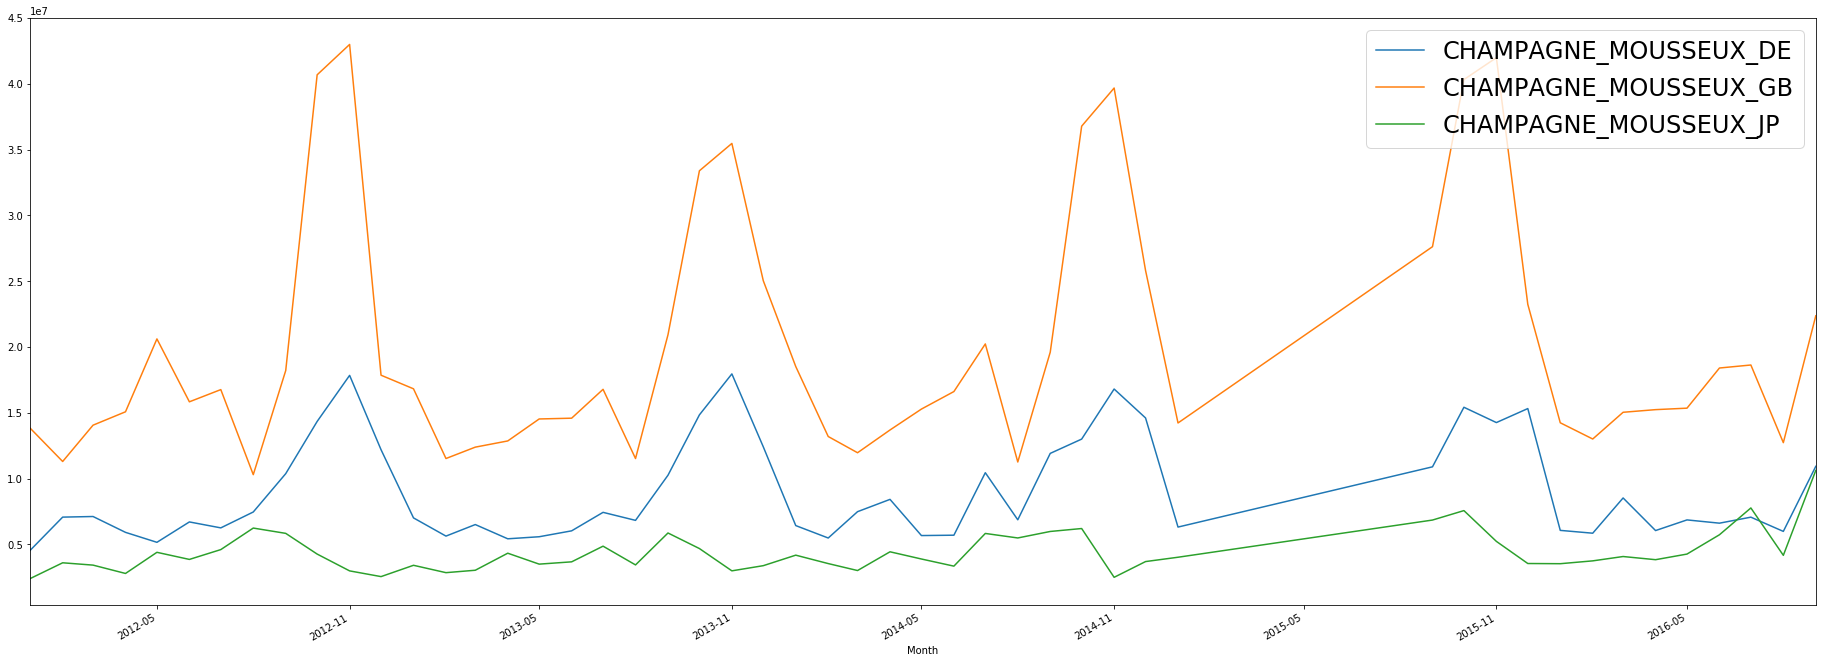

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

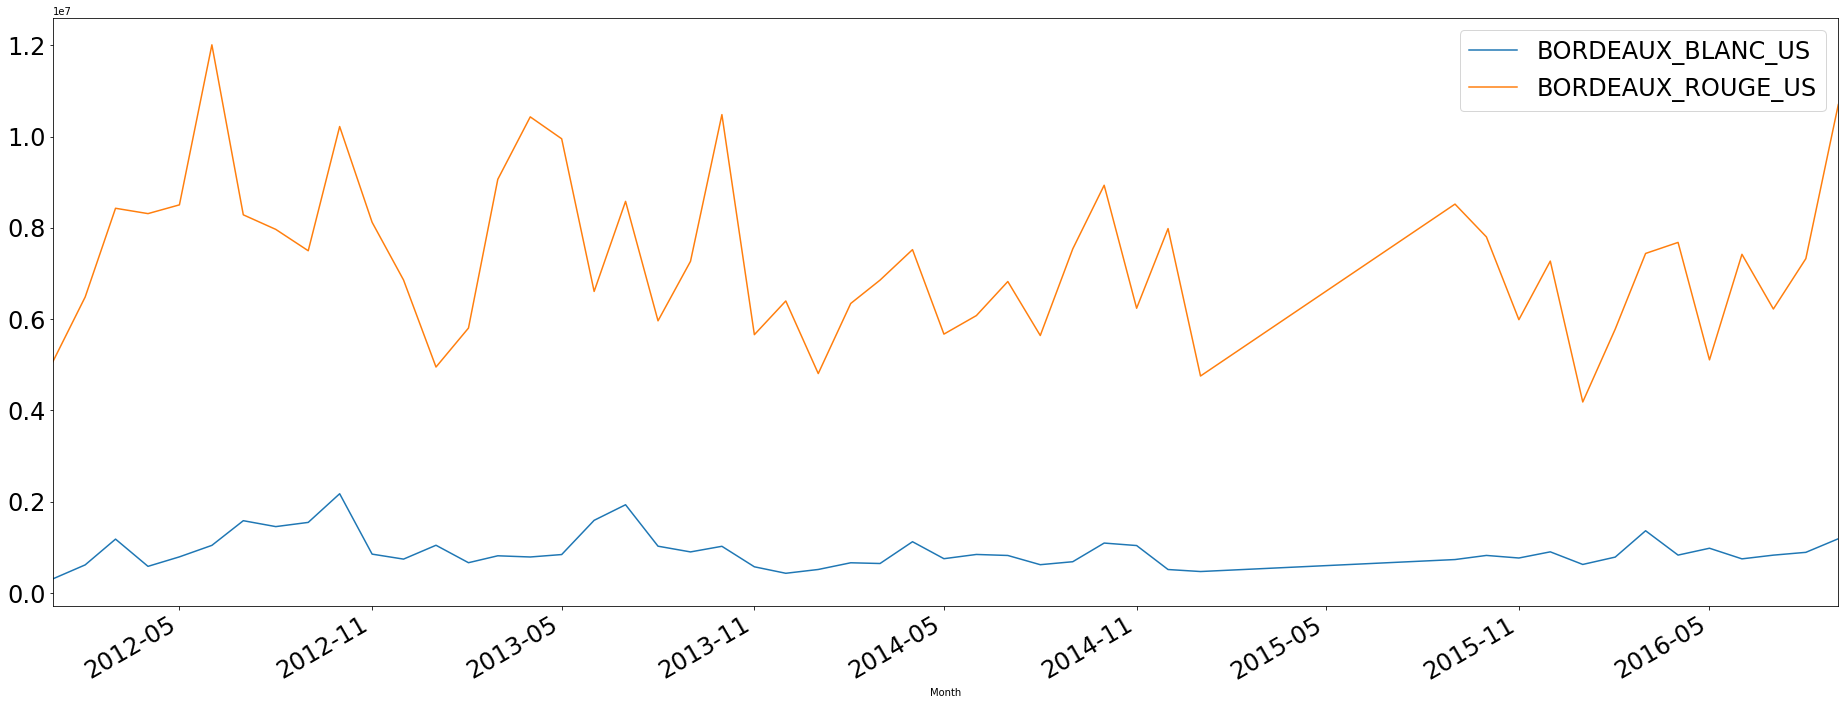

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


,ALSACE_BLANC_CN,BEAUJOLAIS_ROUGE_CN,BORDEAUX_BLANC_CN,BORDEAUX_ROUGE_CN,BOURGOGNE_BLANC_CN,BOURGOGNE_ROUGE_CN,CHAMPAGNE_MOUSSEUX_CN,EUROPE_ROUGE_CN,FRANCE_BLANC_CN,FRANCE_MOUSSEUX_CN,FRANCE_ROUGE_CN,LANGUEDOC_ROUGE_CN,LOIRE_BLANC_CN,LOIRE_ROUGE_CN,OTHER_ROUGE_CN,RHÔNE_ROUGE_CN
count,50.000000,50.00000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01
mean,119348.360000,130292.47000,4.993186e+05,1.138432e+07,242575.340000,7.436432e+05,6.225160e+05,8.313372e+05,12978.062000,93298.256667,11185.281403,1.304245e+06,48771.330000,92016.740000,52969.948000,7.498312e+05
std,65116.609016,102214.45714,2.936971e+05,3.081051e+06,99492.736867,4.176045e+05,3.812781e+05,2.337996e+05,24705.479992,63521.773261,13888.069451,6.352887e+05,27922.200988,54704.609614,36129.014739,3.592653e+05
min,19546.000000,5833.00000,1.678740e+05,5.377235e+06,75396.000000,2.725460e+05,1.976760e+05,3.270090e+05,0.000000,20488.500000,260.500000,4.916860e+05,16643.500000,15325.000000,6337.750000,1.888270e+05
25%,82278.500000,66206.50000,3.117738e+05,9.737536e+06,171633.250000,4.214805e+05,3.897600e+05,6.529608e+05,1607.250000,46355.750000,4759.017857,9.207640e+05,31191.250000,54588.250000,28779.650000,5.089532e+05
50%,98656.000000,98427.50000,4.148980e+05,1.039686e+07,237099.500000,6.060540e+05,5.299100e+05,8.078685e+05,6237.750000,82644.583333,8837.333333,1.211934e+06,37845.750000,77491.500000,44118.875000,7.065070e+05
75%,161694.000000,158673.75000,5.623658e+05,1.316721e+07,308119.750000,9.648268e+05,7.029695e+05,9.859902e+05,14842.000000,118693.250000,12869.584821,1.416010e+06,62140.375000,119915.500000,62176.000000,9.285735e+05
max,317661.000000,453985.00000,1.890312e+06,1.905088e+07,535157.000000,2.021852e+06,2.103130e+06,1.367882e+06,163701.000000,366064.500000,96564.222222,3.607517e+06,151128.000000,272948.000000,179114.750000,1.755449e+06


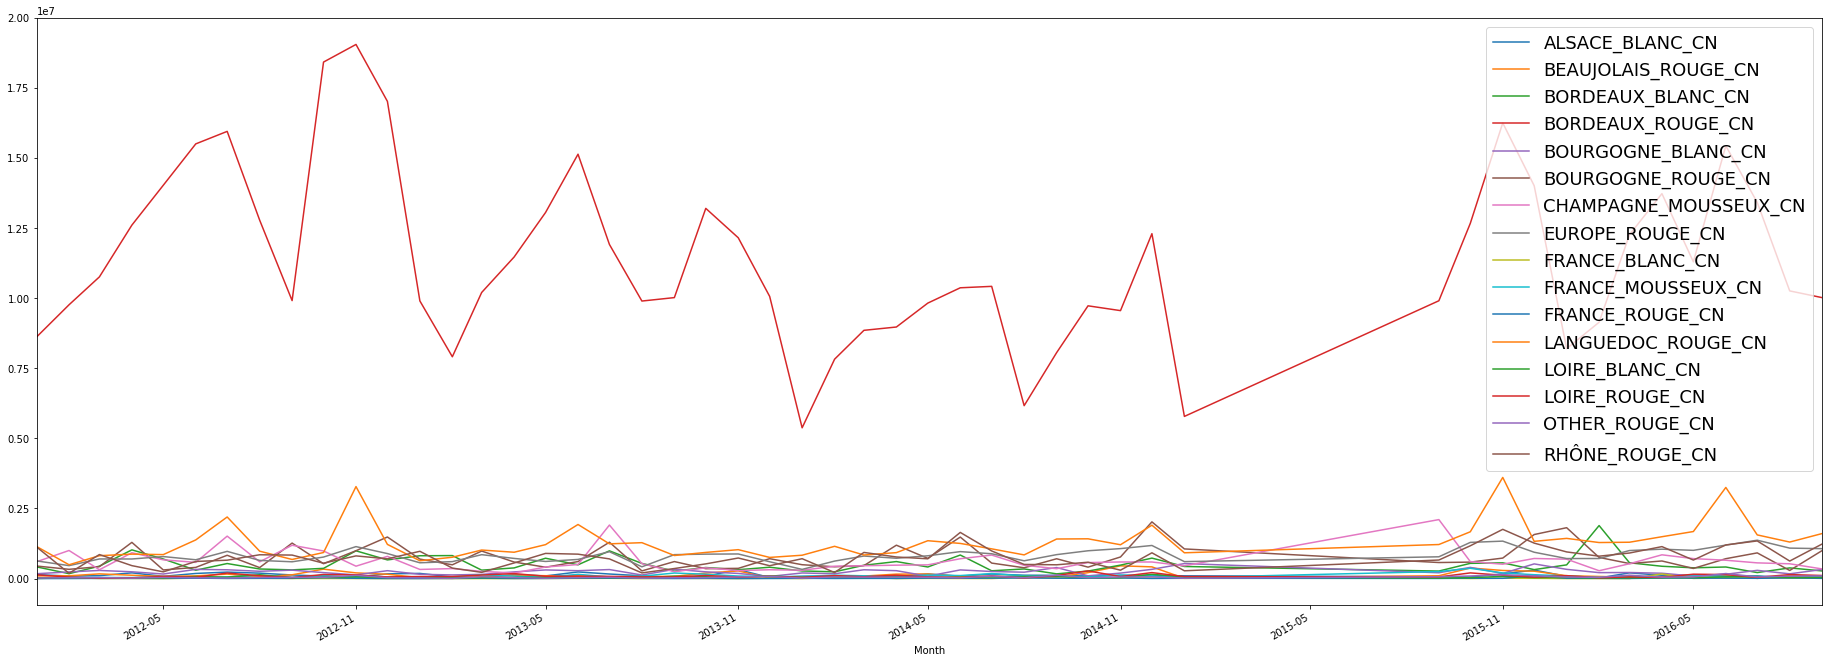

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


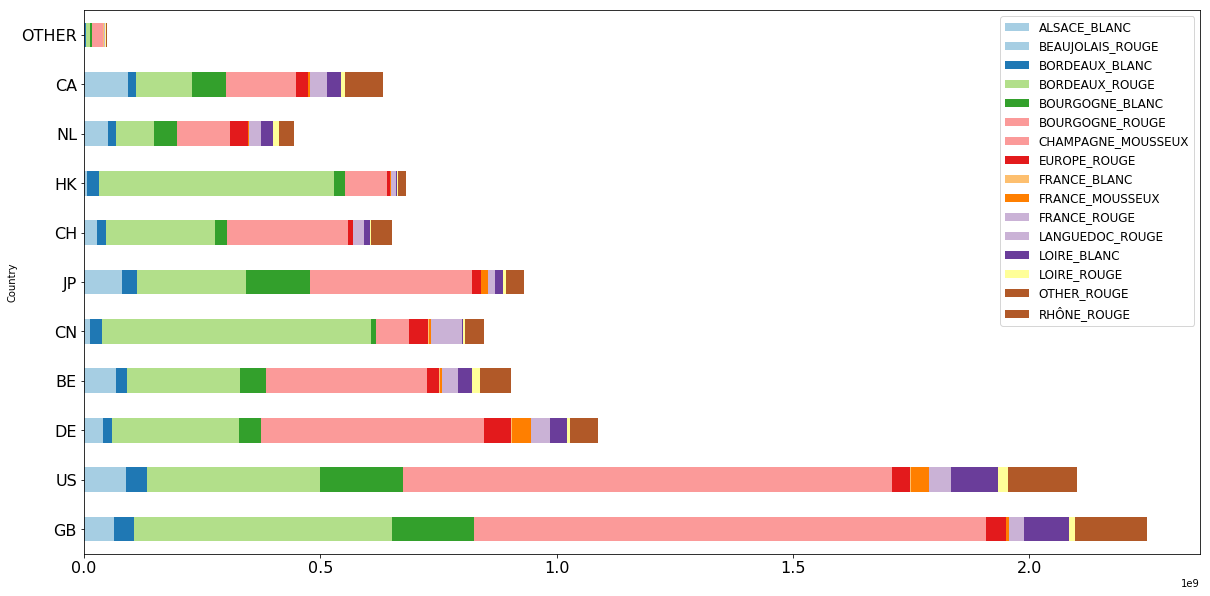

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Hierarchy Definition


Here, we start by defining as hierarchical to forecast wolrdwide wine export by forecasting country and continent exports.

A country export is computed by afgregating all wine types and variants exported to that country.

In this section, we describe the definition of the hierarchy. 
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Hierarchy defintion
rows_list = [];
for v in Variants:
    for w in Wines:
        for c in Countries:
            col = w + "_" + v + "_" + c;
            region = lDict[c]
            if(col in French_Wine_Export_in_Euros_DF.columns):
                rows_list.append([col , c , region , 'WORLD']);
            
lLevels = ['Wine' , 'Country' , 'Region' , 'WORLD'];
lHierarchy = {};
lHierarchy['Levels'] = lLevels;
lHierarchy['Data'] = pd.DataFrame(rows_list, columns =  lLevels);
lHierarchy['Type'] = "Hierarchical";

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Data':                    Wine Country   Region  WORLD
 0       ALSACE_BLANC_GB      GB   EUROPE  WORLD
 1       ALSACE_BLANC_US      US  AMERICA  WORLD
 2       ALSACE_BLANC_DE      DE   EUROPE  WORLD
 3       ALSACE_BLANC_BE      BE   EUROPE  WORLD
 4       ALSACE_BLANC_CN      CN     ASIA  WORLD
 5     BORDEAUX_BLANC_GB      GB   EUROPE  WORLD
 6     BORDEAUX_BLANC_US      US  AMERICA  WORLD
 7     BORDEAUX_BLANC_DE      DE   EUROPE  WORLD
 8     BORDEAUX_BLANC_BE      BE   EUROPE  WORLD
 9     BORDEAUX_BLANC_CN      CN     ASIA  WORLD
 10  BEAUJOLAIS_ROUGE_GB      GB   EUROPE  WORLD
 11  BEAUJOLAIS_ROUGE_US      US  AMERICA  WORLD
 12  BEAUJOLAIS_ROUGE_DE      DE   EUROPE  WORLD
 13  BEAUJOLAIS_ROUGE_BE      BE   EUROPE  WORLD
 14  BEAUJOLAIS_ROUGE_CN      CN     ASIA  WORLD
 15    BORDEAUX_ROUGE_GB      GB   EUROPE  WORLD
 16    BORDEAUX_ROUGE_US      US  AMERICA  WORLD
 17    BORDEAUX_ROUGE_DE      DE   EUROPE  WORLD
 18    BORDEAUX_ROUGE_BE      BE   EUROPE  WORLD
 19    BORDE

We plot the hierarchy ...


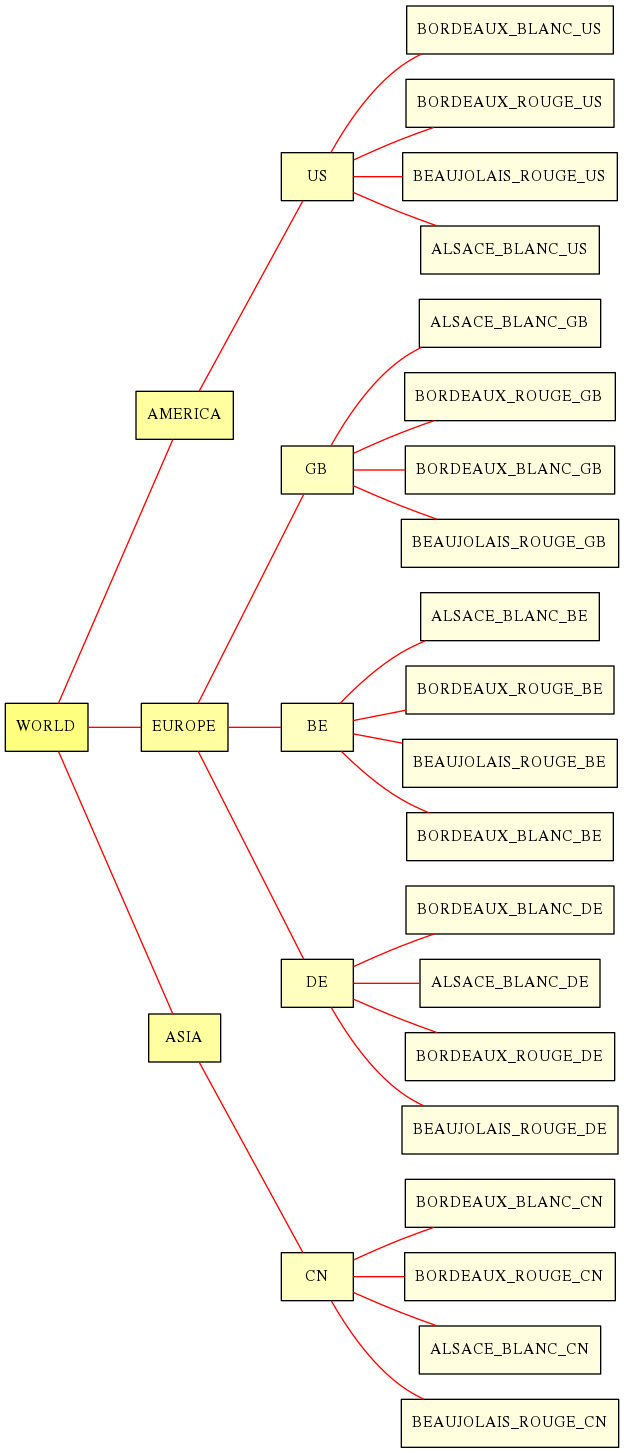

In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'BE': {'ALSACE_BLANC_BE',
   'BEAUJOLAIS_ROUGE_BE',
   'BORDEAUX_BLANC_BE',
   'BORDEAUX_ROUGE_BE'},
  'CN': {'ALSACE_BLANC_CN',
   'BEAUJOLAIS_ROUGE_CN',
   'BORDEAUX_BLANC_CN',
   'BORDEAUX_ROUGE_CN'},
  'DE': {'ALSACE_BLANC_DE',
   'BEAUJOLAIS_ROUGE_DE',
   'BORDEAUX_BLANC_DE',
   'BORDEAUX_ROUGE_DE'},
  'GB': {'ALSACE_BLANC_GB',
   'BEAUJOLAIS_ROUGE_GB',
   'BORDEAUX_BLANC_GB',
   'BO

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.2 KB


In [21]:
lInfo = lEngine.to_json()
lInfo.keys()

dict_keys(['Structure', 'Models'])

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'BE': {'ALSACE_BLANC_BE',
   'BEAUJOLAIS_ROUGE_BE',
   'BORDEAUX_BLANC_BE',
   'BORDEAUX_ROUGE_BE'},
  'CN': {'ALSACE_BLANC_CN',
   'BEAUJOLAIS_ROUGE_CN',
   'BORDEAUX_BLANC_CN',
   'BORDEAUX_ROUGE_CN'},
  'DE': {'ALSACE_BLANC_DE',
   'BEAUJOLAIS_ROUGE_DE',
   'BORDEAUX_BLANC_DE',
   'BORDEAUX_ROUGE_DE'},
  'GB': {'ALSACE_BLANC_GB',
   'BEAUJOLAIS_ROUGE_GB',
   'BORDEAUX_BLANC_GB',
   'BO

In [23]:
lInfo['Models'].keys()

dict_keys(['ALSACE_BLANC_BE', 'BEAUJOLAIS_ROUGE_DE', 'DE', 'EUROPE', 'BORDEAUX_BLANC_DE', 'WORLD', 'ALSACE_BLANC_DE', 'BORDEAUX_ROUGE_DE', 'BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'CN', 'BORDEAUX_ROUGE_US', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_GB', 'US', 'BORDEAUX_ROUGE_BE', 'ALSACE_BLANC_CN', 'AMERICA', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'ALSACE_BLANC_US', 'BORDEAUX_BLANC_US', 'ASIA', 'BEAUJOLAIS_ROUGE_CN', 'BE', 'BORDEAUX_BLANC_BE', 'GB', 'ALSACE_BLANC_GB', 'BORDEAUX_ROUGE_GB'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Signal': 'BORDEAUX_ROUGE_CN',
  'Time': {'Horizon': 1,
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'TimeVariable': 'Month'},
  'Training_Signal_Length': 46},
 'Model': {'AR_Model': 'AR(11)',
  'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)',
  'Cycle': 'NoCycle',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend'},
 'Model_Performance': {'COMPLEXITY': '43',
  'MAPE': '0.2347',
  'RMSE': '2843102.00162'}}

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model           RMSE    MAPE
28                WORLD  5468299.97928  0.1274
3       ALSACE_BLANC_GB  66480.1666393  0.1402
25               EUROPE  4129993.44338  0.1529
26                   GB  1567222.43948  0.1579
21    BORDEAUX_ROUGE_GB  1259434.91006  0.1592
16    BORDEAUX_BLANC_GB  124261.308579  0.1631
7                    BE  1159467.76843  0.1664
18    BORDEAUX_ROUGE_BE   921082.27271  0.1915
2       ALSACE_BLANC_DE  146095.120401  0.1938
22    BORDEAUX_ROUGE_US  1513545.98789  0.2029
17    BORDEAUX_BLANC_US  252977.835616  0.2096
5               AMERICA  2096609.43198  0.2209
27                   US  2096609.43198  0.2209
23                   CN  2736005.06261  0.2269
6                  ASIA  2736005.06261  0.2269
4       ALSACE_BLANC_US  175530.247685  0.2323
19    BORDEAUX_ROUGE_CN  2843102.00162  0.2347
24                   DE  1311702.05848  0.2377
15    BORDEAUX_BLANC_DE  201387.259056  0.2533
20    BORDEAUX_ROUGE_DE  1164082.87845  0.2672
12  BEAUJOLAI

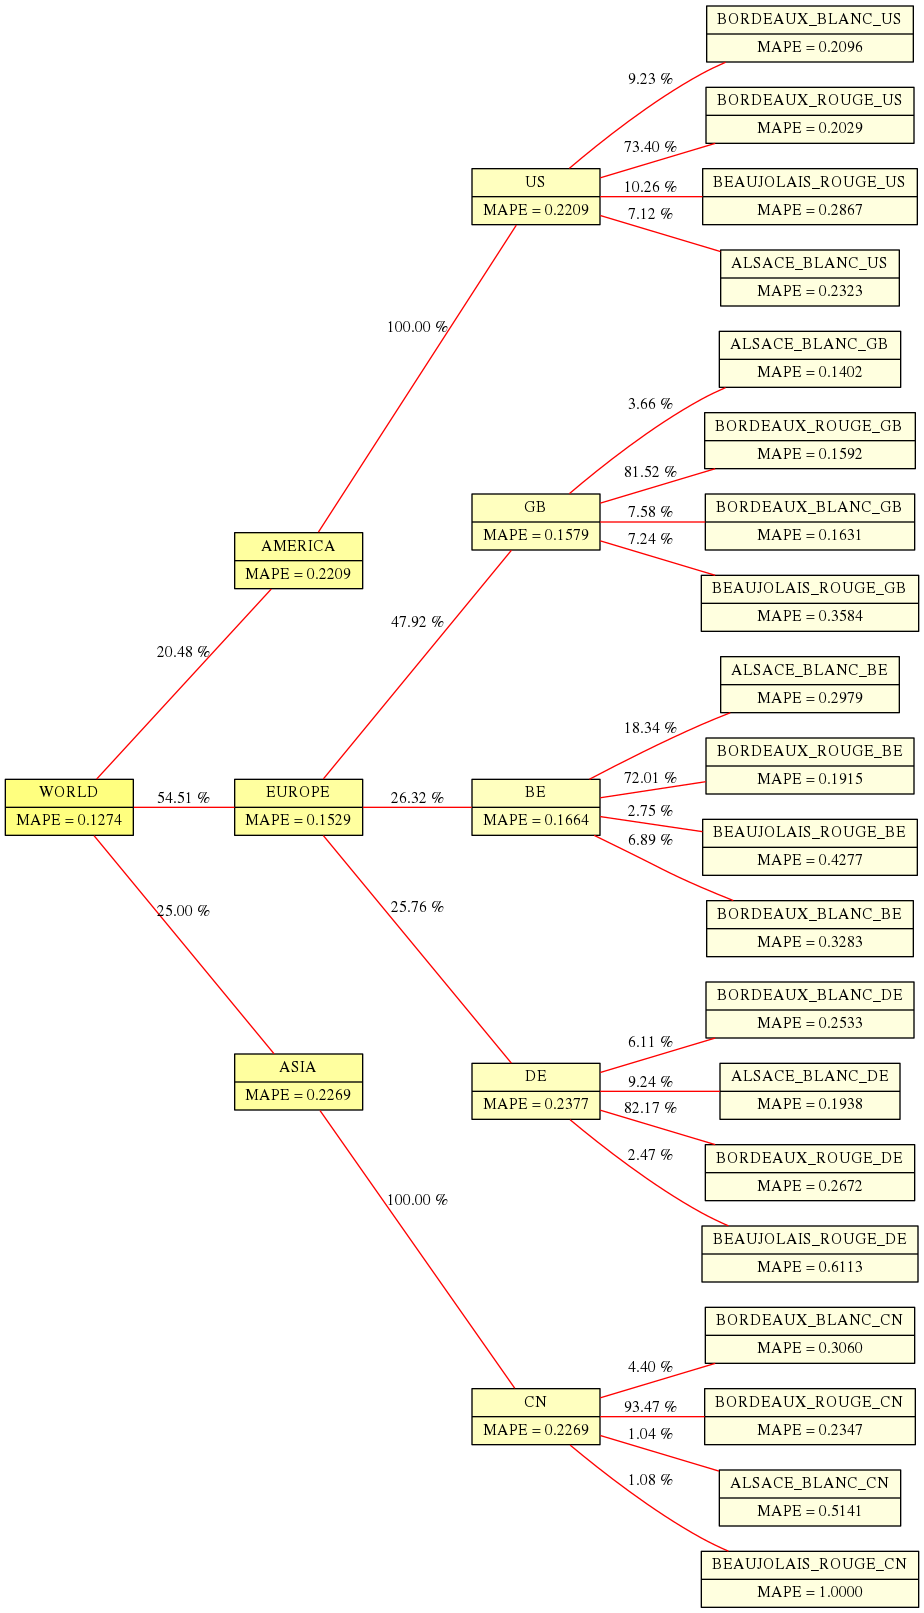

In [26]:
lEngine.mSignalHierarchy.plot()

In [29]:
BORDEAUX_ROUGE_CN_Engine = lEngine.mSignalHierarchy.mModels[0]['BORDEAUX_ROUGE_CN']

In [30]:
BORDEAUX_ROUGE_CN_Engine.getModelInfo()

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1400: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


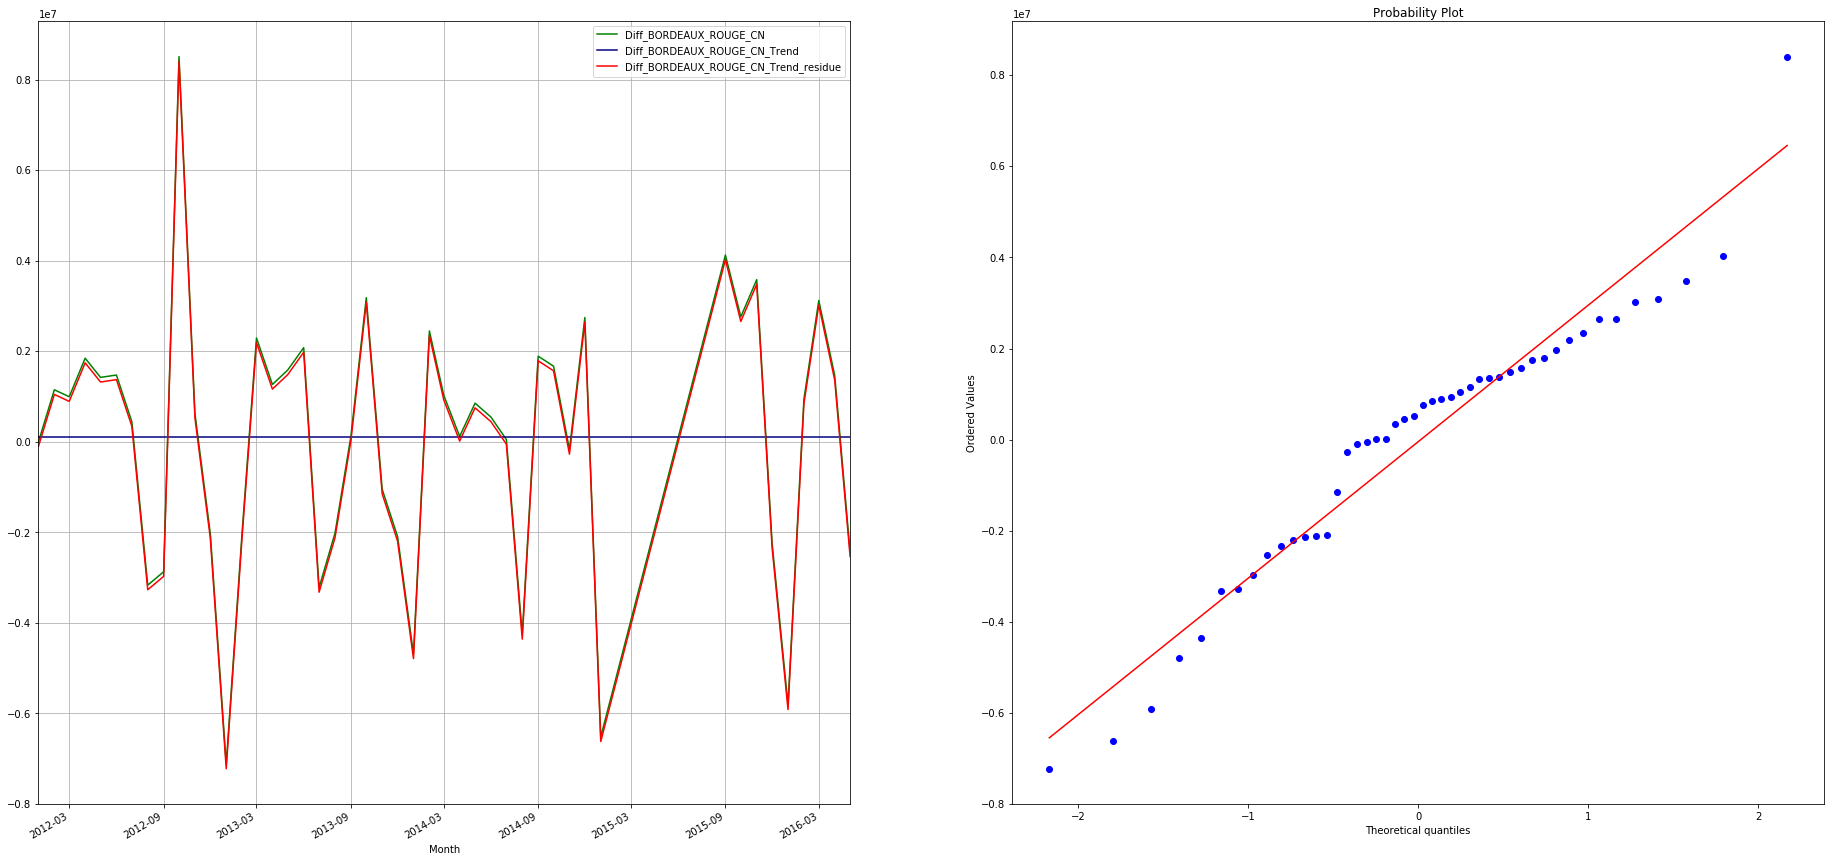

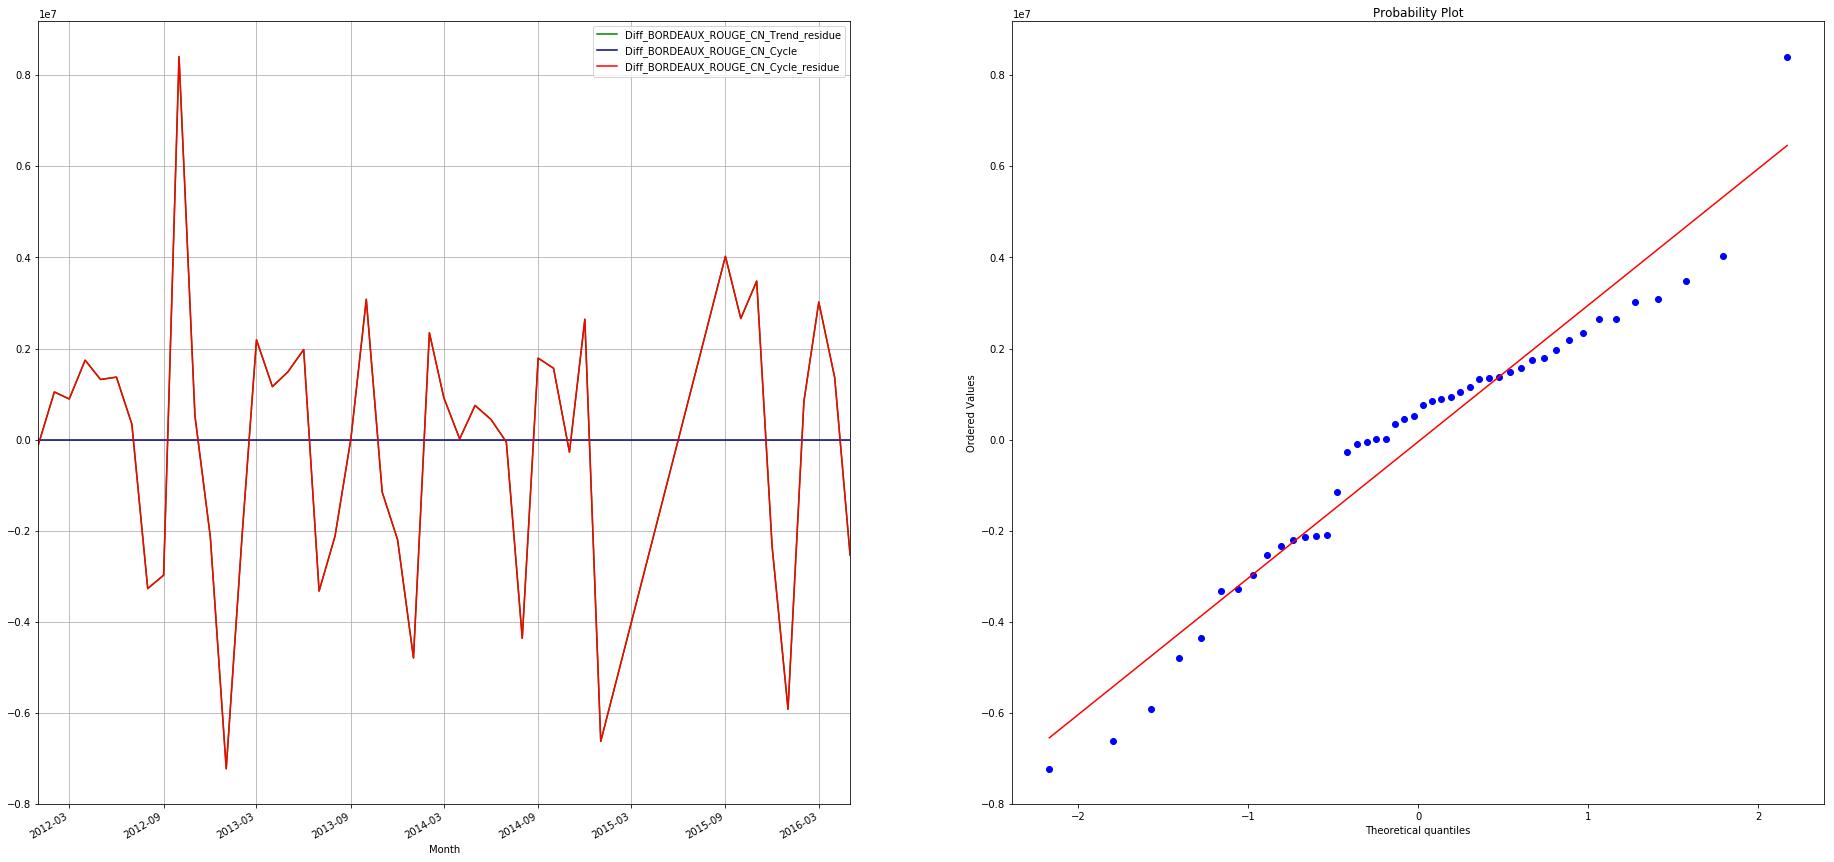

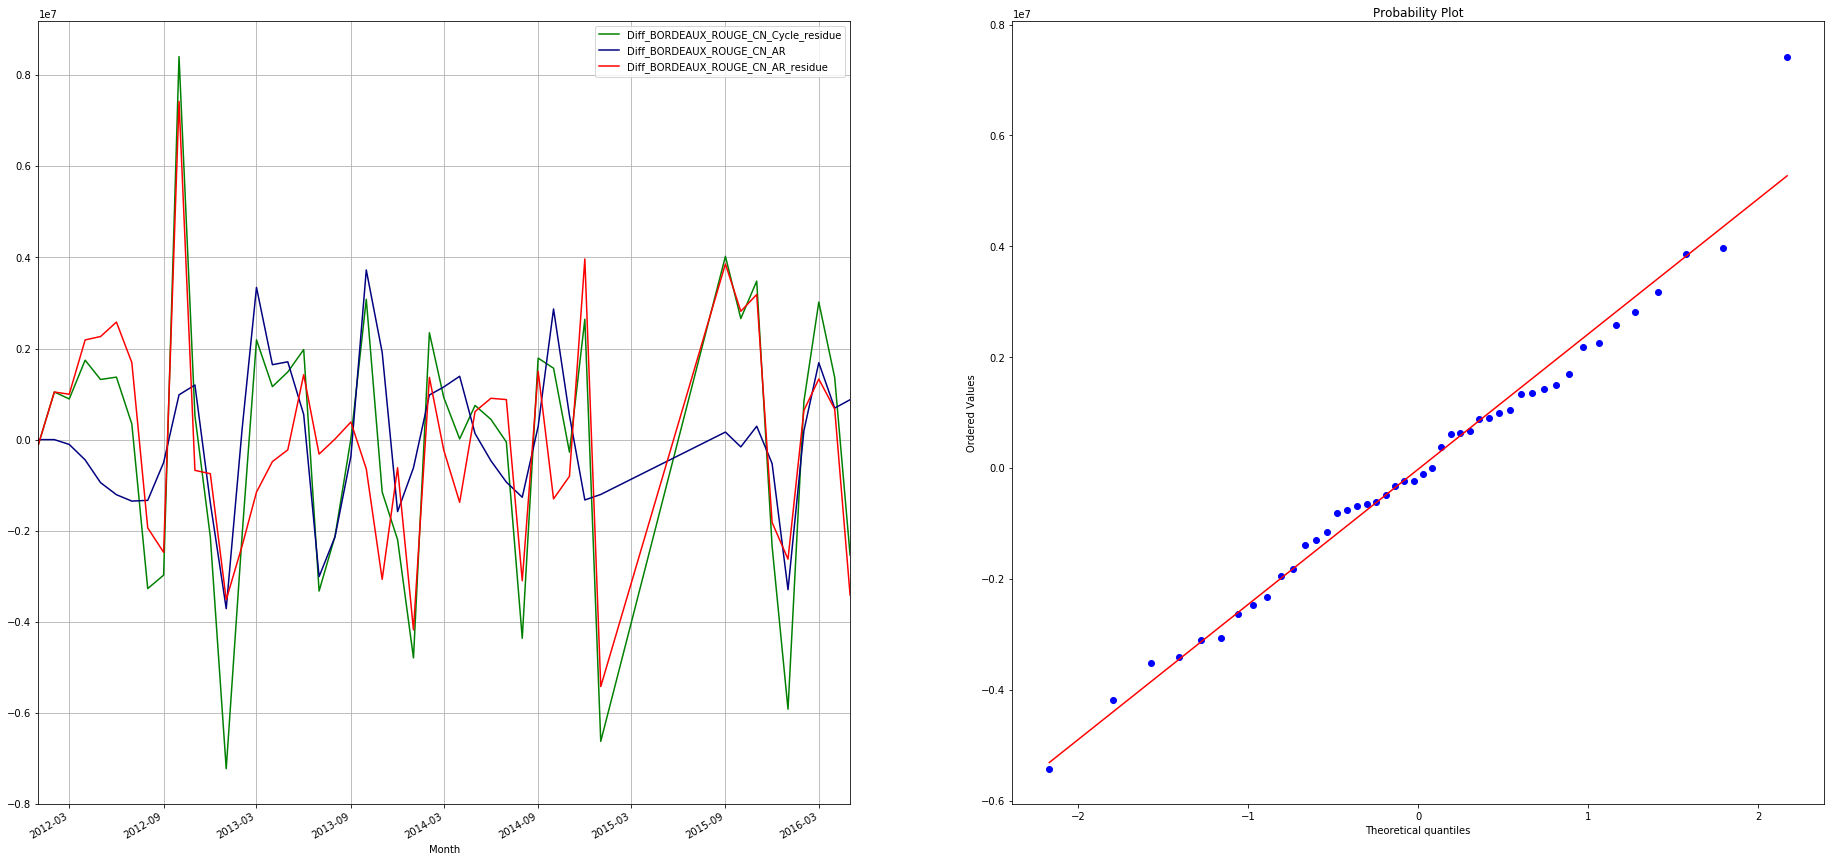

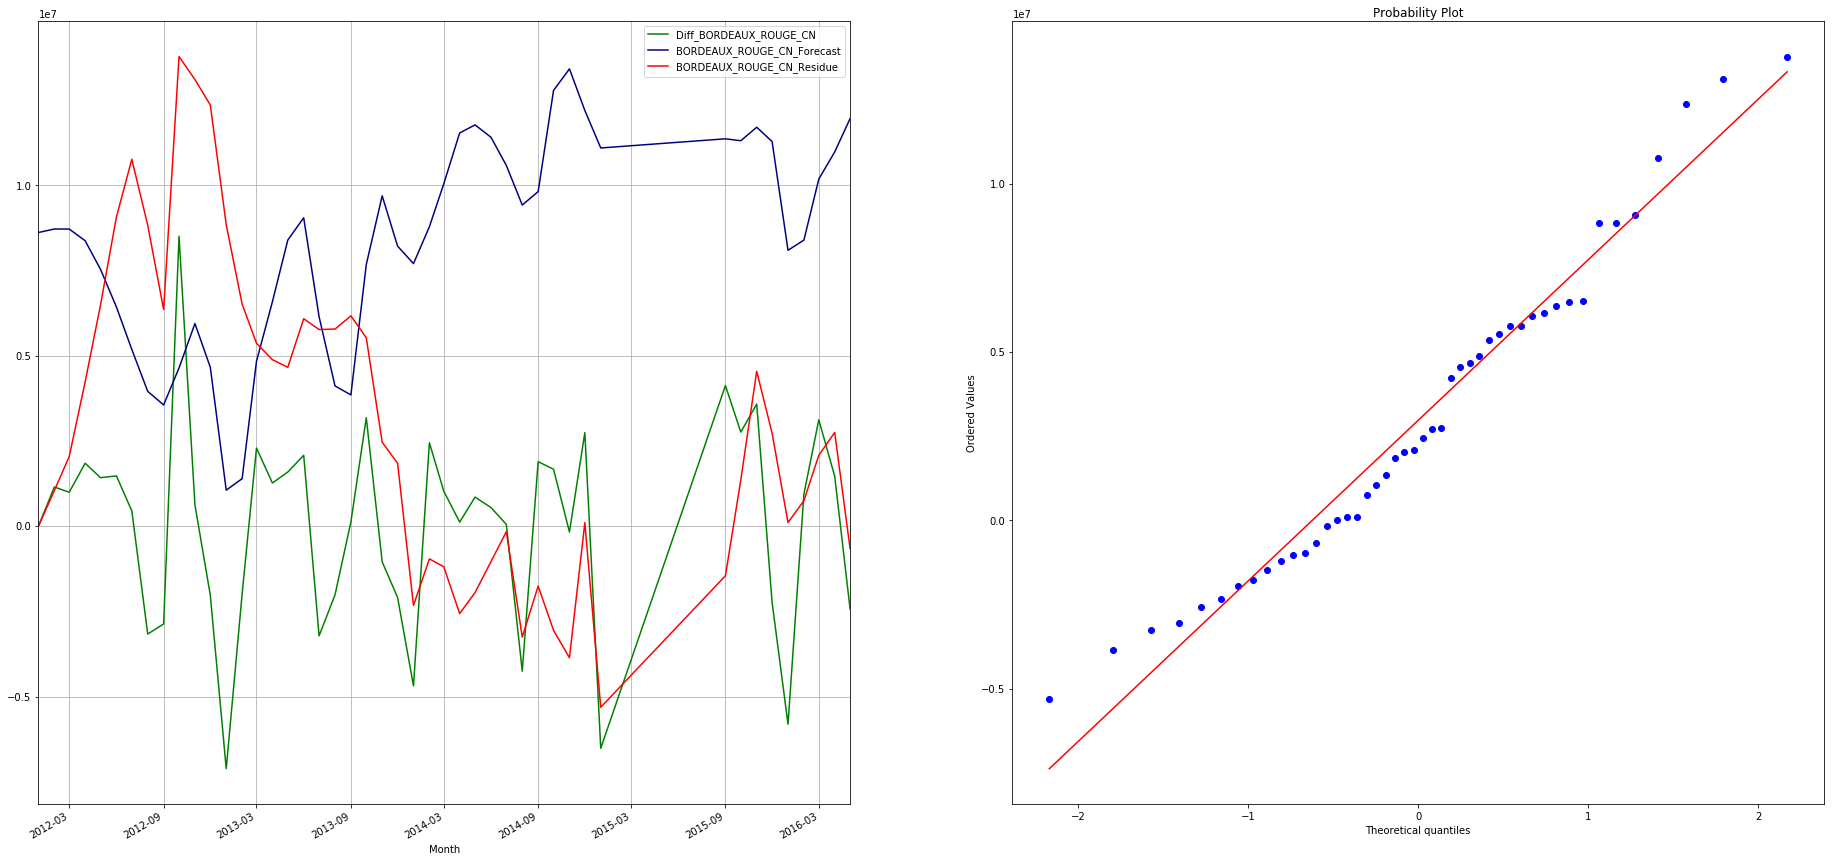

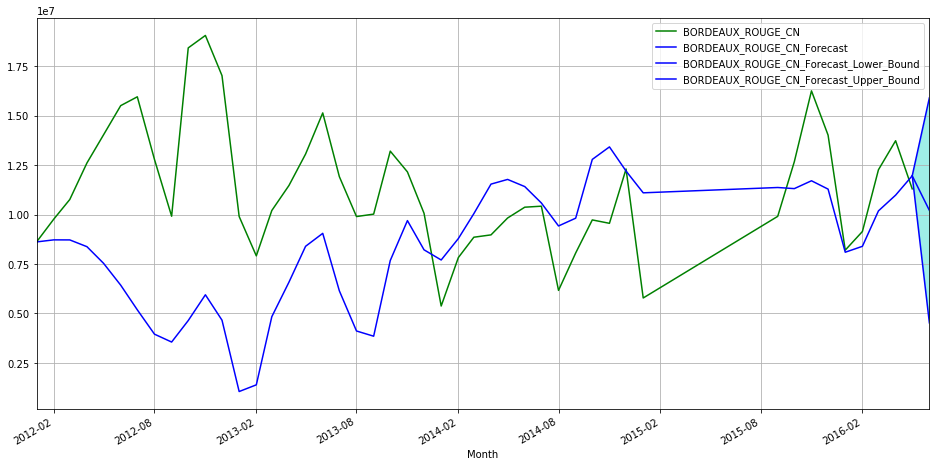

In [28]:
BORDEAUX_ROUGE_CN_Engine.standrdPlots()